In [1]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as python_random

import tensorflow as tf
import tensorflow_hub as hub

yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle) # if there's an "SavedModel file does not exist at:", delete that folder and rerun it

2023-02-24 10:20:31.687731: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-24 10:20:35.764980: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [24]:
df_all = pd.read_csv('../train_val_test_sgkf_Feb24.csv', index_col=0)
df_all

# Convert data into TF format

In [25]:
filenames = df_all['file']
targets = df_all['category']
folds = df_all['fold']

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))
main_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [26]:
def load_wav_pkl(filename, wav_label='y'):
    import pickle
    # open a file, where you stored the pickled data
    file = open(filename, 'rb')

    # dump information to that file
    output = pickle.load(file)
    wav = output[wav_label]

    # close the file
    file.close()
    return wav

wav_list = []
for index, row in df_all.iterrows():
    if len(load_wav_pkl(row['file'])) == 160000:
        wav_list.append(load_wav_pkl(row['file']))
    else: # if the waveform is shorter (for unknown reason)
        temp_wav = load_wav_pkl(row['file'])
        print('short length: '+str(len(temp_wav)))
        wav_list.append(np.pad(temp_wav, (0,160000-len(temp_wav)),'mean')) # zero-padding at the end to 160000

wav_bg_list = []
for index, row in df_all.iterrows():
    if len(load_wav_pkl(row['file'], 'bg_y')) == 160000:
        wav_bg_list.append(load_wav_pkl(row['file'], 'bg_y'))
    else: # if the waveform is shorter (for unknown reason)
        temp_wav = load_wav_pkl(row['file'], 'bg_y')
#         print('short length: '+str(len(temp_wav)))
        wav_bg_list.append(np.pad(temp_wav, (0,160000-len(temp_wav)),'mean')) # zero-padding at the end to 160000

wav_fg_list = []
for index, row in df_all.iterrows():
    if len(load_wav_pkl(row['file'], 'fg_y')) == 160000:
        wav_fg_list.append(load_wav_pkl(row['file'], 'fg_y'))
    else: # if the waveform is shorter (for unknown reason)
        temp_wav = load_wav_pkl(row['file'], 'fg_y')
#         print('short length: '+str(len(temp_wav)))
        wav_fg_list.append(np.pad(temp_wav, (0,160000-len(temp_wav)),'mean')) # zero-padding at the end to 160000

short length: 151461
short length: 148006
short length: 159999
short length: 153242
short length: 159880
short length: 151683
short length: 159880
short length: 159997
short length: 146099
short length: 159880
short length: 157848
short length: 159993
short length: 156480
short length: 159880
short length: 159992
short length: 153357
short length: 67456


In [27]:
main_ds = tf.data.Dataset.from_tensor_slices((np.stack(wav_list, axis = 0), df_all['category'], df_all['fold'], df_all['weight']))
main_ds_fg = tf.data.Dataset.from_tensor_slices((np.stack(wav_fg_list, axis = 0), df_all['category'], df_all['fold'], df_all['weight']))
main_ds_bg = tf.data.Dataset.from_tensor_slices((np.stack(wav_bg_list, axis = 0), df_all['category'], df_all['fold'], df_all['weight']))


# applies the embedding extraction model to a wav data
def extract_embedding_weight(wav_data, label, fold, weight):
    # run YAMNet to extract embedding from the wav data
    scores, embeddings, spectrogram = yamnet_model(wav_data)
    num_embeddings = tf.shape(embeddings)[0]
    return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings),
            tf.repeat(weight, num_embeddings))

# extract embedding
main_ds = main_ds.map(extract_embedding_weight).unbatch()
main_ds_fg = main_ds_fg.map(extract_embedding_weight).unbatch()
main_ds_bg = main_ds_bg.map(extract_embedding_weight).unbatch()

In [28]:
def split_ds(main_ds):
    cached_ds = main_ds.cache()
    train_ds = cached_ds.filter(lambda embedding, label, fold, weight: fold < 8)
    val_ds = cached_ds.filter(lambda embedding, label, fold, weight: fold == 8)
    test_ds = cached_ds.filter(lambda embedding, label, fold, weight: fold == 9)

    # remove the folds column now that it's not needed anymore
    remove_fold_column = lambda embedding, label, fold, weight: (embedding, label, weight)

    train_ds = train_ds.map(remove_fold_column)
    val_ds = val_ds.map(remove_fold_column)
    test_ds = test_ds.map(remove_fold_column)

    train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
    val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
    test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
    
    return train_ds, val_ds, test_ds

In [29]:
train_ds, val_ds, test_ds = split_ds(main_ds)
train_ds_bg, val_ds_bg, test_ds_bg = split_ds(main_ds_bg)
train_ds_fg, val_ds_fg, test_ds_fg = split_ds(main_ds_fg)

# Model of raw signal

In [30]:
my_classes = ['city', 'nature']
tf.keras.backend.clear_session()
tf.random.set_seed(23)
np.random.seed(23)
python_random.seed(23)


raw_model = tf.keras.Sequential([
#     tf.keras.layers.Dropout(.5, input_shape=(1024,), name='input_embedding'),
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(len(my_classes))
], name='raw_model')

raw_model.summary()

Model: "raw_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 525,826
Trainable params: 525,826
Non-trainable params: 0
_________________________________________________________________


In [31]:
adam = tf.keras.optimizers.Adam(learning_rate=0.001)

raw_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=adam,
#                     optimizer="adam",
                  weighted_metrics=[],
                    metrics=['accuracy'])

# callback will be used in the other models below too
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)

In [32]:
history = raw_model.fit(train_ds,
                       epochs=20,
                       validation_data=val_ds,
                       callbacks=callback)

Epoch 1/20
2848/2848 [==============================] - 402s 139ms/step - loss: 0.0010 - accuracy: 0.8265 - val_loss: 0.0013 - val_accuracy: 0.8256
Epoch 2/20
2848/2848 [==============================] - 13s 5ms/step - loss: 9.5162e-04 - accuracy: 0.8424 - val_loss: 0.0013 - val_accuracy: 0.8190
Epoch 3/20
2848/2848 [==============================] - 13s 5ms/step - loss: 9.3826e-04 - accuracy: 0.8437 - val_loss: 0.0013 - val_accuracy: 0.8305
Epoch 4/20
2848/2848 [==============================] - 13s 4ms/step - loss: 8.8401e-04 - accuracy: 0.8523 - val_loss: 0.0014 - val_accuracy: 0.8495
Epoch 5/20
2848/2848 [==============================] - 13s 5ms/step - loss: 8.4513e-04 - accuracy: 0.8553 - val_loss: 0.0014 - val_accuracy: 0.8381
Epoch 6/20
2848/2848 [==============================] - 14s 5ms/step - loss: 8.2753e-04 - accuracy: 0.8579 - val_loss: 0.0015 - val_accuracy: 0.8451
Epoch 7/20
2848/2848 [==============================] - 14s 5ms/step - loss: 8.0480e-04 - accuracy: 0.8611 

In [33]:
# this is the accuracy per YAMNet sample, not the accuracy per audio file
loss, accuracy = raw_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

353/353 [==============================] - 7s 9ms/step - loss: 0.0013 - accuracy: 0.8501
Loss:  0.001266126288101077
Accuracy:  0.8500886559486389


In [34]:
def acc_by_audio(model, test_ds, y_true):
    n_sample_per_audio = 20
    y_pred = model.predict(test_ds)
    y_reshaped = y_pred.reshape(-1, n_sample_per_audio, 2) # reshape to audio*sample*binary_prediction
    y_pred_by_row = y_reshaped.mean(axis=1).argmax(axis=1)
    from sklearn.metrics import accuracy_score
    return accuracy_score(y_true, y_pred_by_row), y_pred_by_row


In [35]:
test_df = df_all[df_all['fold']==9]
acc, y_pred = acc_by_audio(raw_model, test_ds, y_true = test_df['category'])
print(acc)

353/353 [==============================] - 1s 2ms/step
0.898936170212766


In [36]:
from sklearn.metrics import accuracy_score
test_df['pred'] = y_pred
acc_source = test_df.groupby(['source']).apply(lambda x: accuracy_score(x['category'], x['pred']))

/var/folders/fw/slnm06yn15lgwlcg_7jpt3t00000gn/T/ipykernel_28291/2037315006.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['pred'] = y_pred


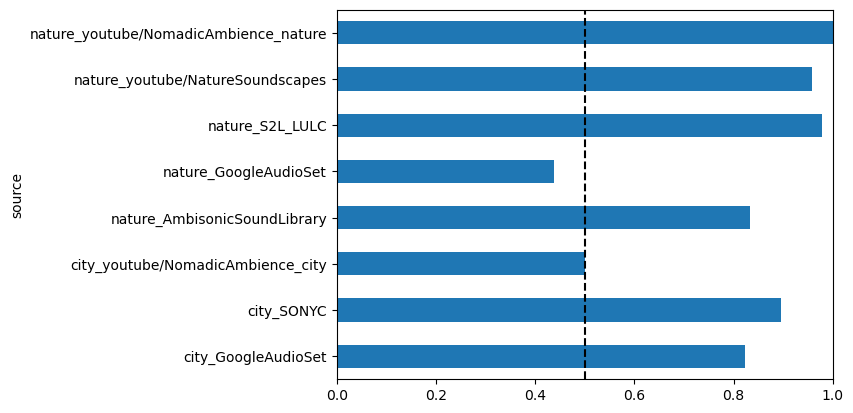

In [37]:
ax = acc_source.plot.barh()
ax.axvline(x=0.5, color='k', linestyle='--')
ax.set_xlim(0,1)
plt.show()

********* below has not been revised (Feb 24)

# Model of background signal

In [25]:
my_classes = ['city', 'nature']
tf.keras.backend.clear_session()
tf.random.set_seed(23)
np.random.seed(23)
python_random.seed(23)


bg_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(my_classes))
], name='bg_model')

bg_model.summary()

Model: "bg_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               131200    
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 131,458
Trainable params: 131,458
Non-trainable params: 0
_________________________________________________________________


In [26]:
bg_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    optimizer="adam",
                    metrics=['accuracy'])

history = bg_model.fit(train_ds_bg,
                       epochs=20,
                       validation_data=val_ds_bg,
                       callbacks=callback)

Epoch 1/20
1247/1247 [==============================] - 172s 134ms/step - loss: 0.2736 - accuracy: 0.8884 - val_loss: 0.2740 - val_accuracy: 0.8830
Epoch 2/20
1247/1247 [==============================] - 2s 2ms/step - loss: 0.2296 - accuracy: 0.9057 - val_loss: 0.2999 - val_accuracy: 0.8719
Epoch 3/20
1247/1247 [==============================] - 2s 2ms/step - loss: 0.2091 - accuracy: 0.9152 - val_loss: 0.3025 - val_accuracy: 0.8772
Epoch 4/20
1247/1247 [==============================] - 2s 2ms/step - loss: 0.1887 - accuracy: 0.9234 - val_loss: 0.3167 - val_accuracy: 0.8791
Epoch 5/20
1247/1247 [==============================] - 2s 2ms/step - loss: 0.1739 - accuracy: 0.9311 - val_loss: 0.3085 - val_accuracy: 0.8906
Epoch 6/20
1247/1247 [==============================] - 2s 2ms/step - loss: 0.1577 - accuracy: 0.9373 - val_loss: 0.3286 - val_accuracy: 0.8800
Epoch 7/20
1247/1247 [==============================] - 4s 3ms/step - loss: 0.1488 - accuracy: 0.9421 - val_loss: 0.3638 - val_accur

In [27]:
loss, accuracy = bg_model.evaluate(test_ds_bg)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

159/159 [==============================] - 2s 6ms/step - loss: 0.8430 - accuracy: 0.8387
Loss:  0.8430272340774536
Accuracy:  0.8387351632118225


In [28]:
test_df = df_all[df_all['fold']==9]
acc, y_pred = acc_by_audio(bg_model, test_ds_bg, y_true = test_df['category'])
print(acc)

159/159 [==============================] - 0s 973us/step
0.8656126482213439


In [29]:
from sklearn.metrics import accuracy_score
test_df['pred'] = y_pred
acc_source = test_df.groupby(['source']).apply(lambda x: accuracy_score(x['category'], x['pred']))

/var/folders/fw/slnm06yn15lgwlcg_7jpt3t00000gn/T/ipykernel_88584/2037315006.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['pred'] = y_pred


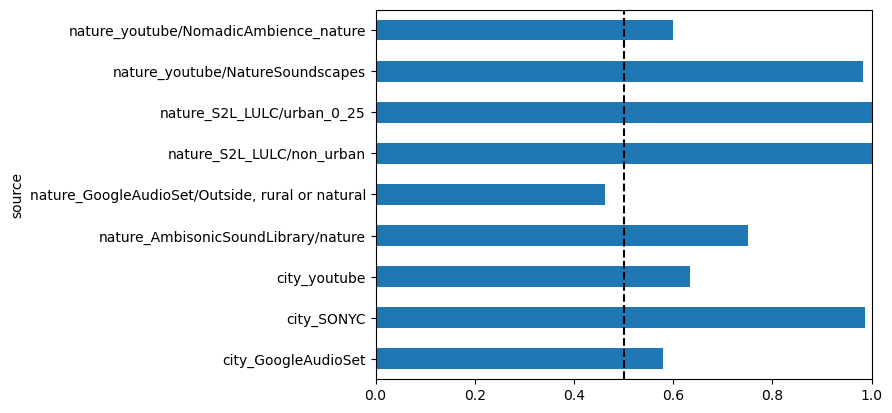

In [30]:
ax = acc_source.plot.barh()
ax.axvline(x=0.5, color='k', linestyle='--')
ax.set_xlim(0,1)
plt.show()

# Model of foreground signal

In [31]:
my_classes = ['city', 'nature']
tf.keras.backend.clear_session()
tf.random.set_seed(23)
np.random.seed(23)
python_random.seed(23)


fg_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(my_classes))
], name='fg_model')

fg_model.summary()

Model: "fg_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               131200    
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 131,458
Trainable params: 131,458
Non-trainable params: 0
_________________________________________________________________


In [32]:
fg_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    optimizer="adam",
                    metrics=['accuracy'])

history = fg_model.fit(train_ds_fg,
                       epochs=20,
                       validation_data=val_ds_fg,
                       callbacks=callback)

Epoch 1/20
1247/1247 [==============================] - 185s 145ms/step - loss: 0.5358 - accuracy: 0.7336 - val_loss: 0.5192 - val_accuracy: 0.7306
Epoch 2/20
1247/1247 [==============================] - 3s 2ms/step - loss: 0.4968 - accuracy: 0.7564 - val_loss: 0.5133 - val_accuracy: 0.7336
Epoch 3/20
1247/1247 [==============================] - 3s 3ms/step - loss: 0.4825 - accuracy: 0.7651 - val_loss: 0.5120 - val_accuracy: 0.7398
Epoch 4/20
1247/1247 [==============================] - 3s 3ms/step - loss: 0.4679 - accuracy: 0.7763 - val_loss: 0.5036 - val_accuracy: 0.7487
Epoch 5/20
1247/1247 [==============================] - 3s 3ms/step - loss: 0.4565 - accuracy: 0.7808 - val_loss: 0.4954 - val_accuracy: 0.7551
Epoch 6/20
1247/1247 [==============================] - 3s 2ms/step - loss: 0.4457 - accuracy: 0.7879 - val_loss: 0.4954 - val_accuracy: 0.7445
Epoch 7/20
1247/1247 [==============================] - 3s 3ms/step - loss: 0.4353 - accuracy: 0.7940 - val_loss: 0.4918 - val_accur

In [33]:
loss, accuracy = fg_model.evaluate(test_ds_fg)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

159/159 [==============================] - 3s 8ms/step - loss: 0.7408 - accuracy: 0.6982
Loss:  0.7407734394073486
Accuracy:  0.6982213258743286


In [34]:
test_df = df_all[df_all['fold']==9]
acc, y_pred = acc_by_audio(fg_model, test_ds_fg, y_true = test_df['category'])
print(acc)

159/159 [==============================] - 0s 1ms/step
0.7905138339920948


In [35]:
from sklearn.metrics import accuracy_score
test_df['pred'] = y_pred
acc_source = test_df.groupby(['source']).apply(lambda x: accuracy_score(x['category'], x['pred']))

/var/folders/fw/slnm06yn15lgwlcg_7jpt3t00000gn/T/ipykernel_88584/2037315006.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['pred'] = y_pred


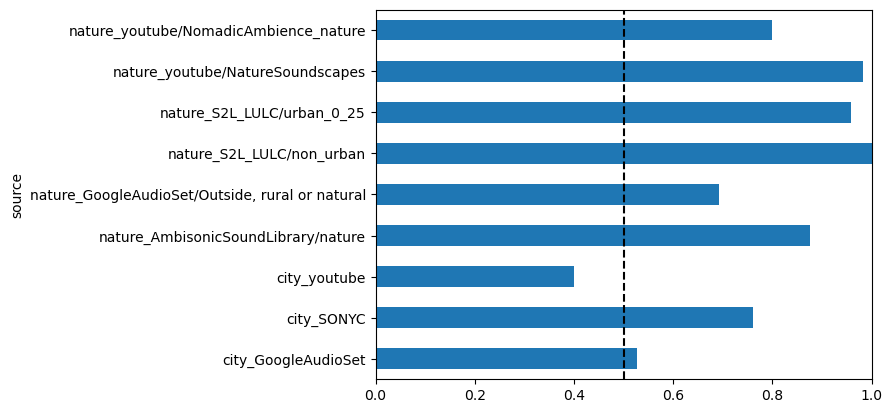

In [36]:
ax = acc_source.plot.barh()
ax.axvline(x=0.5, color='k', linestyle='--')
ax.set_xlim(0,1)
plt.show()

# Model of 3 signals

In [37]:
# my_classes = ['city', 'nature']
# tf.keras.backend.clear_session()
# tf.random.seta_seed(23)

# all3_model = tf.keras.Sequential([
#     tf.keras.layers.Input(shape=(3072), dtype=tf.float32,
#                           name='input_embedding'),
#     tf.keras.layers.Dense(1024, activation='relu'),
# #     tf.keras.layers.Dense(1024, activation='relu'),
#     tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.Dense(len(my_classes))
# ], name='all3_model')

# all3_model.summary()

In [38]:
# all3_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#                     optimizer="adam",
#                     metrics=['accuracy'])

# # callback will be used in the other models below too
# callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
#                                             patience=3,
#                                             restore_best_weights=True)


# history = all3_model.fit(train_ds_3,
#                        epochs=20,
#                        validation_data=val_ds_3,
#                        callbacks=callback)

In [39]:
# loss, accuracy = all3_model.evaluate(test_ds_3)

# print("Loss: ", loss)
# print("Accuracy: ", accuracy)

In [40]:
# test_df = df_all[df_all['fold']==9]
# acc = acc_by_audio(all3_model, test_ds_3, y_true = test_df['category'])
# print(acc)